Cf. [タイタニック号の乗客の生存予測〜80%以上の予測精度を超える方法（探索的データ解析編）](https://yolo-kiyoshi.com/2018/12/16/post-951/)

### 🚢 EDA
(探索的データ解析)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
train_raw = pd.read_csv('csv/train.csv') # 学習データ 
test_raw = pd.read_csv('csv/test.csv')   # テストデータ
print('The size of the train data:' + str(train_raw.shape))
print('The size of the test data:' + str(test_raw.shape))

The size of the train data:(891, 12)
The size of the test data:(418, 11)


In [3]:
print('Missing value of train data: \n', train_raw.isnull().sum())
print('Missing value of t data: \n', test_raw.isnull().sum())

Missing value of train data: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Missing value of t data: 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
train_mid = train_raw.copy()
test_mid = test_raw.copy()
train_mid['train_or_test'] = 'train' # 学習データフラグ 
test_mid['train_or_test'] = 'test'   # テストデータフラグ
test_mid['Survived'] = 9 # テストにSurvivedデータを仮置き

alldata = pd.concat([train_mid, test_mid], sort=False, axis=0).reset_index(drop=True)
print('The size of the alldata data:' + str(aiidata.shape))

### 🚢 頻度
（生存率のベースライン）

In [5]:
train_raw['Survived'].mean() # 学習データに於ける生存率

0.3838383838383838

### 🚢 説明変数別分析

#### - Pclass
階級別での生存率を探索

In [6]:
# Pclass別の生存率
train_raw['Survived'].groupby(train_raw['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

/Users/t/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='count'>

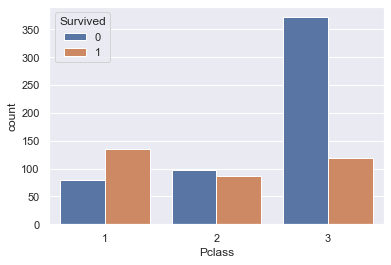

In [7]:
# Pclass別の生存数カウント
sns.countplot(train_raw['Pclass'], hue=train_raw['Survived'])

In [8]:
# Pclass分布(学習データとテストデータ間のPclassの乗客数の分布に大きな偏りを探す)
pd.crosstab(alldata['Pclass'], alldata['train_or_test'], normalize='columns')

train_or_test,test,train
Pclass,,
1,0.255981,0.242424
2,0.222488,0.206510
3,0.521531,0.551066


#### - Name
乗客の名前から新たな特徴量を探索
```
英語表記の名前は,
first name, middle name, last nameで表現されていて、
このmiddle nameの部分になんらかの情報が含まれていそうです。
```

In [9]:
# Nameの確認
train_raw['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [10]:
# ミドルネーム＝敬称（honorific）を抽出
train_raw['honorific'] = train_raw['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
train_raw['honorific'].value_counts() #敬称別のレコード数

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Don               1
Mme               1
Sir               1
Ms                1
Lady              1
Capt              1
Jonkheer          1
the Countess      1
Name: honorific, dtype: int64

In [11]:
# テストデータの敬称(honorific)を抽出
alldata['honorific'] = alldata['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
pd.crosstab(alldata['honorific'],alldata['train_or_test']) #敬称別のレコード数

train_or_test,test,train
honorific,,
Capt,0,1
Col,2,2
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,0,1
Major,0,2
Master,21,40


In [12]:
# 学習データにしか現れない敬称を除外
only_train_honorific = ['Capt','Don','Jonkheer','Lady','Major','Mile','Mme','Sir','the Countess']
train_omit1 = train_raw[~train_raw['honorific'].isin(only_train_honorific) ].reset_index(drop=True)
# 敬称別の生存率とレコード数
train_omit1['Survived'].groupby(train_omit1['honorific']).agg(['mean','count'])

,mean,count
honorific,,
Col,0.500000,2
Dr,0.428571,7
Master,0.575000,40
Miss,0.697802,182
Mlle,1.000000,2
Mr,0.156673,517
Mrs,0.792000,125
Ms,1.000000,1
Rev,0.000000,6


In [13]:
train_omit1['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #少数派の敬称を統合
train_omit1['honorific'].replace(['Mlle', 'Ms'], 'Miss',inplace=True) #Missに統合
# 敬称別の生存率
train_omit1['Survived'].groupby(train_omit1['honorific']).agg(['mean','count'])

,mean,count
honorific,,
Master,0.575000,40
Miss,0.702703,185
Mr,0.156673,517
Mrs,0.792000,125
Rare,0.266667,15


#### - Fare
運賃別の生存率を探索


/Users/t/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/t/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


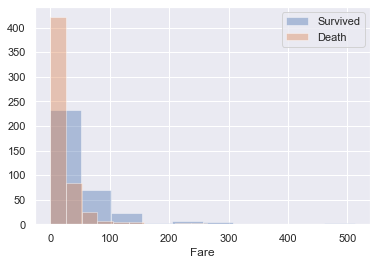

In [14]:
# Fareの分布
sns.distplot(train_raw[train_raw['Survived']==1]['Fare'],kde=False,rug=False,bins=10,label='Survived')
sns.distplot(train_raw[train_raw['Survived']==0]['Fare'],kde=False,rug=False,bins=10,label='Death')
plt.legend()

In [15]:
print("Skewness of Fare:", train_raw['Fare'].skew()) #Fareの歪度（skewness）

Skewness of Fare: 4.787316519674893


/Users/t/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/t/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


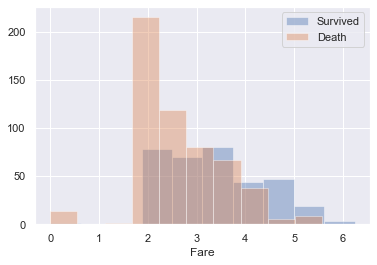

In [16]:
# 分布が歪んでいるためFareを対数変換して再度分布を確認
sns.distplot(np.log1p(train_raw[train_raw['Survived']==1]['Fare']),kde=False,rug=False,bins=10,label='Survived')
sns.distplot(np.log1p(train_raw[train_raw['Survived']==0]['Fare']),kde=False,rug=False,bins=10,label='Death')
plt.legend()

### - Age
Ageはそもそも欠損が多い変数です。
Ageが欠損しているってことは死亡しているからそもそもデータが取れていないんじゃ？

In [17]:
# Ageの欠損有無よる生存率差
train_raw['Survived'].groupby(train_raw['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

/Users/t/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/t/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


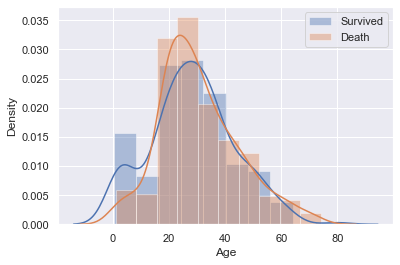

In [18]:
# Ageの欠損を除外
train_age_omit = train_raw.dropna(subset=['Age'])
# Ageの分布
sns.distplot(train_age_omit[train_age_omit['Survived']==1]['Age'],kde=True,rug=False,bins=10,label='Survived') #生存者の分布
sns.distplot(train_age_omit[train_age_omit['Survived']==0]['Age'],kde=True,rug=False,bins=10,label='Death') #死者の分布
plt.legend()

### - FamilySize

```=(Parch+Sibsp+1)```

与えられたデータには存在しない、FamilySize(家族数)という変数を追加して分布を確認

/Users/t/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FamilySize', ylabel='count'>

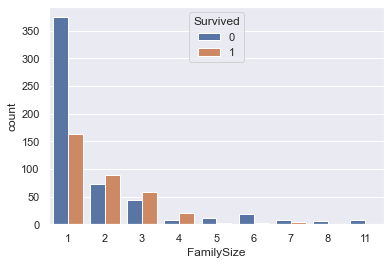

In [19]:
# 家族数 = Parch + SibSp + 1
train_raw['FamilySize'] = train_raw['Parch'] + train_raw['SibSp'] + 1 #学習データ
alldata['FamilySize'] = alldata['Parch'] + alldata['SibSp'] + 1 #ALLデータ
# 家族数ごとの分布を確認
sns.countplot(train_raw['FamilySize'],hue=train_raw['Survived'])

FamilySizeと生存の間に線形関係がなさそうなのでビニング処理をします。

    ビニング処理（ビン分割）とは、連続値を任意の境界値で区切りカテゴリ分けして離散値に変換する処理のこと。 
    機械学習の前処理として行われることが多い。
    例えば、年齢のデータを10代、20代の層（水準）ごとに分けるといった処理。
    
    pd.cut()

In [20]:
# FamilySizeを離散化
train_raw['FamilySize_bin'] = 'big'
train_raw.loc[train_raw['FamilySize']==1,'FamilySize_bin'] = 'alone'
train_raw.loc[(train_raw['FamilySize']>=2) & (train_raw['FamilySize']<=4),'FamilySize_bin'] = 'small'
train_raw.loc[(train_raw['FamilySize']>=5) & (train_raw['FamilySize']<=7),'FamilySize_bin'] = 'mediam'
# FamilySizeを離散化したときの生存率
train_raw['Survived'].groupby(train_raw['FamilySize_bin']).mean()

FamilySize_bin
alone     0.303538
big       0.000000
mediam    0.204082
small     0.578767
Name: Survived, dtype: float64

### - Cabin
    部屋番号別による生存率
    かなり欠損値が多く特徴量としては省かれがち。
    しかし、調べてみると、Cabin（部屋番号）の頭文字に応じて部屋の階層が異なっていたようです。


In [21]:
# Cabinの頭文字
train_raw['Cabin_ini'] = train_raw['Cabin'].map(lambda x:str(x)[0])
alldata['Cabin_ini'] = alldata['Cabin'].map(lambda x:str(x)[0])
# Cabinの頭文字別の生存率とレコード数
train_raw['Survived'].groupby(train_raw['Cabin_ini']).agg(['mean','count'])

,mean,count
Cabin_ini,,
A,0.466667,15
B,0.744681,47
C,0.593220,59
D,0.757576,33
E,0.750000,32
F,0.615385,13
G,0.500000,4
T,0.000000,1
n,0.299854,687


In [22]:
# Cabinの頭文字別のカウント数
pd.crosstab(alldata['Cabin_ini'],alldata['train_or_test'])

train_or_test,test,train
Cabin_ini,,
A,7,15
B,18,47
C,35,59
D,13,33
E,9,32
F,8,13
G,1,4
T,0,1
n,327,687


### - Ticket

In [23]:
train_raw['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [24]:
train_raw['Survived'].groupby(train_raw['Ticket'].map(lambda x: str(x)[0])).agg(['mean','count'])

,mean,count
Ticket,,
1,0.630137,146
2,0.464481,183
3,0.239203,301
4,0.200000,10
5,0.000000,3
6,0.166667,6
7,0.111111,9
8,0.000000,2
9,1.000000,1


In [25]:
# 学習データとテストデータの分布を確認
pd.crosstab(alldata['Ticket'].map(lambda x: str(x)[0]),alldata['train_or_test'])

train_or_test,test,train
Ticket,,
1,64,146
2,95,183
3,128,301
4,1,10
5,0,3
6,3,6
7,4,9
8,0,2
9,1,1


Text(0.5, 1.0, 'frequency of ticket')

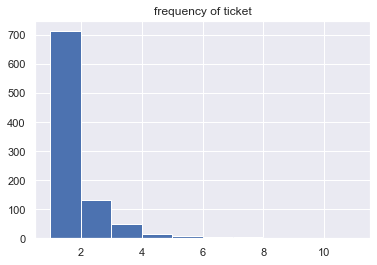

In [26]:
# Ticketの頻度のヒストグラム
plt.hist(alldata.Ticket.value_counts())
plt.title('frequency of ticket')

In [27]:
# Ticket頻度別の生存率
alldata.loc[:, 'TicketFreq'] = alldata.groupby(['Ticket'])['PassengerId'].transform('count')
alldata.query('train_or_test == "train"').groupby(['TicketFreq'])['Survived'].agg(['mean','count'])

,mean,count
TicketFreq,,
1,0.270270,481
2,0.513812,181
3,0.653465,101
4,0.727273,44
5,0.333333,21
6,0.210526,19
7,0.208333,24
8,0.384615,13
11,0.000000,7
